In [1]:
!pip install casadi
!pip install scipy
!pip install celluloid #convenient package for making animations

In [2]:
import time
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
import pdb
from random import sample
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from IPython.display import HTML
from celluloid import Camera                  


## Simulator
The class defines the Traffic Intersection and Highway environments. It simulates the Ego Vehicle (EV) and Target Vehicle (TV) with LTI system dynamics, and also includes the mode-dependent control logic for the TV. It also has a prediction module that can be used for the constraints in the Stochastic MPC defined ahead.

In [3]:

class Simulator():
    '''
    For ENV= "TI"::  Simulates a traffic intersection with 1 Ego vehicle (EV) and 2 target vehicles (TVs).
    The TVs can be in one of two modes: Cross intersection or stop

    For ENV= "HW"::  Simulates a Highway with 1 Ego vehicle (EV) and 1 target vehicles (TVs).
    The TVs can be in one of two modes: drive straight or change into EV's lane

    '''

    def __init__(self,
                DT          = 0.1,
                T_FINAL     = 300,
                MODE        = 0,
                S_FINAL     = 50,
                TV_SPEED    = 8.,
                TV_L        = 2.,
                ENV         = "TI",
                EV_POLICY_TYPE = "SMPC_IA"
                ):

        self.env=ENV
        self.ev_pol=EV_POLICY_TYPE

        self.t=0
        self.dt= DT
        self.T=T_FINAL

        # Half length and half width of the cars
        self.hl=2.9
        self.hw=1.7

        # EV states: x,y,v_x
        self.A=np.array([[1., 0., self.dt],[0., 1., 0.], [0., 0., 1.]])
        self.B=np.array([0.,0.,self.dt])



        self.u_prev=0.

        self.tv_v=TV_SPEED
        self.tv_l=TV_L



        if self.env=="TI":
            self.ev_init=np.array([-42., 0., 10])
            self.ev_traj=np.zeros((3,self.T+1))
            self.ev_u=np.zeros((1,self.T))
            self.ev_traj[:,0]=self.ev_init


            self.tv_init= [np.array([26., 35., -15.]), np.array([36., -36., 13.])]
            self.N_TV=len(self.tv_init)

            # Control gains for TV: Fast policy, Stop policy
            self.gains=[[.1,0.2], [2,2.5]]
            self.IA_gains=[0.1,1]

            self.N_modes=4
            ## mode = 0, TV1 fast, TV2 fast
            ## mode = 1, TV1 fast, TV2 slow
            ## mode = 2, TV1 slow, TV2 fast
            ## mode = 3, TV1 slow, TV2 slow

            # Final longitudinal position
            self.s_f=50.
            # o_c1, o_c2 are controller parameters for the TVs
            # o_c1 denotes the desired longitudinal distance accross the intersection
            # o_c2 denotes the desired stopping distance from the intersection
            self.o_c1=20.
            self.o_c2=7.5      #Use this for comparing CL vs OL 
            # self.o_c2=6.      #Use this for comparing IA vs no-IA and OBCA vs ellipse
            self.mode=MODE


            # TV states: x,y,v_y
            self.Atv=np.array([[1., 0., 0.],[0., 1., self.dt], [0., 0., 1.]])
            self.Btv=self.B

            self.noise_std=[0.01, 0.01, 0.01, 0.2]
        else:
            self.ev_init=np.array([-37.5, 0., 11])
            self.ev_traj=np.zeros((3,self.T+1))
            self.ev_u=np.zeros((1,self.T))
            self.ev_traj[:,0]=self.ev_init


            self.tv_init= [np.array([-20., 8., 0.])]
            self.N_TV=len(self.tv_init)

            # Control gains for TV: straight policy, lane change policy
            self.gains=[[0.,0.], [0.02,1]]
            self.IA_gains=[0.01,0.05]

            self.N_modes=2
            ## mode = 0, TV straight
            ## mode = 1, TV changes lane


            self.s_f=50.
            # o_c1, o_c2 are controller parameters for the TVs
            # o_c1 is a parameter used in the IA controller
            # o_c2 denotes the desired lateral coordinate
            self.o_c1=10.
            self.o_c2=0.
            self.mode=MODE


            # TV states: x,y,psi
            self.Atv=np.array([[1., 0., 0.],[0., 1., self.tv_v*self.dt], [0., 0., 1.]])
            self.Btv=np.array([0.,0.,self.tv_v/2/self.tv_l*self.dt]) 

            self.noise_std=[0.001, 0.001, 0.02, 0.01]


        self.tv_traj=[np.zeros((3,self.T+1)) for k in range(self.N_TV)]

        for k in range(self.N_TV):
            self.tv_traj[k][:,0]=self.tv_init[k]





    def TV_gen(self):
        '''
        Checks if TVs have reached the end and spawns new TVs for Traffic Intersection Environment
        '''
        if self.tv_traj[0][1,self.t]< -self.o_c1:
            self.tv_traj[0][:,self.t]=self.tv_init[0]
            mode_list=[(self.mode+2)%4, self.mode]
            # self.mode=sample(mode_list,1)[0]
            # self.mode=(self.mode+2)%4

        if self.tv_traj[1][1,self.t]> self.o_c1:
            self.tv_traj[1][:,self.t]=self.tv_init[1]
            mode_list=[self.mode+(-1)**(self.mode), self.mode]
            self.mode=self.mode+(-1)**(self.mode)
            #Uncomment to randomize modes for second TV
#             self.mode=sample(mode_list,1)[0]


    def done(self):
        return self.t==self.T or self.s_f-self.ev_traj[0,self.t]<=0.1

    def get_update_dict(self, N, *args):

        if self.t==0:
            z_lin=[np.zeros((3,N+1))]*self.N_modes
            u_tvs=[[np.zeros(N) for j in range(self.N_modes)] for k in range(self.N_TV)]
            elim_mode=0. 
            ev_cross=0.
        else:
            z_lin, u_tvs, elim_mode, ev_cross =self._get_preds(N, *args)

        update_dict={'x0': self.ev_traj[0,self.t], 'y0': self.ev_traj[1,self.t], 'v0':self.ev_traj[2,self.t], 'u_prev':self.u_prev,
                     'x_tv0': np.array([self.tv_traj[k][0,self.t] for k in range(self.N_TV)]), 'y_tv0': np.array([self.tv_traj[k][1,self.t] for k in range(self.N_TV)]), 'v_tv0': np.array([self.tv_traj[k][2,self.t] for k in range(self.N_TV)]),
                     'z_lin': z_lin, 'u_tvs': u_tvs, 'elim_mode': elim_mode, 'ev_cross': ev_cross}

        if len(args)!=0:
            if "OBCA" not in self.ev_pol:
                [h,M,K,nom_z_tv]=args
                update_dict.update({'ws':[h,M,K]})
            else:
                [h,M,K,lmbd,nu,nom_z_tv]=args
                update_dict.update({'ws':[h,M,K,lmbd,nu]})

        return update_dict


    def run_step(self, u_ev):

        rng=np.random.default_rng(self.t)

        self.ev_traj[:,self.t+1]=self.A@self.ev_traj[:,self.t]+self.B*u_ev\
                                    +np.array([rng.normal(0,self.noise_std[0]), 0., rng.normal(0,self.noise_std[1])])
        self.ev_traj[2,self.t+1]=np.max([.0, self.ev_traj[2,self.t+1] ])
        self.ev_u[:,self.t]=u_ev
        self.u_prev=u_ev
        u_tv=[]

        ## The following implements the corresponding controller for each TV,
        ## depending on the mode and whether they are interaction aware (IA) or not
        if self.env=="TI":

            if "IA" not in self.ev_pol:
                ## The following maps the current mode to one of these scenarios and implements the corresponding controller

                if int(self.mode/2)==0: # TV1 in fast mode
                    # PD control with reference (s_ref,v_ref)=(-o_c1, 0)
                    u_tv.append(self.gains[0][0]*( -self.o_c1-self.tv_traj[0][1,self.t])
                                +self.gains[0][1]*( 0.-self.tv_traj[0][2,self.t]))
                else:                   # TV1 in slow mode
                    # PD control with reference (s_ref,v_ref)=(o_c2, 0)
                    u_tv.append(self.gains[1][0]*( self.o_c2-self.tv_traj[0][1,self.t])
                                +self.gains[1][1]*( 0.-self.tv_traj[0][2,self.t]))


                if self.mode%2==0:      # TV2 in fast mode
                    # PD control with reference (s_ref,v_ref)=(o_c1, 0)
                    u_tv.append(self.gains[0][0]*( self.o_c1-self.tv_traj[0][1,self.t])
                                +self.gains[0][1]*( 0.-self.tv_traj[0][2,self.t]))
                else:                   # TV2 in slow mode
                    # PD control with reference (s_ref,v_ref)=(-o_c2, 0)
                    u_tv.append(self.gains[1][0]*( -self.o_c2-self.tv_traj[1][1,self.t])
                                +self.gains[1][1]*( 0.-self.tv_traj[1][2,self.t]))

            else:

                if int(self.mode/2)==0: # TV1 in fast mode, with same controller as non-IA case

                    u_tv.append(self.gains[0][0]*( -self.o_c1-self.tv_traj[0][1,self.t])
                                +self.gains[0][1]*( 0.-self.tv_traj[0][2,self.t]))
                else:                   # TV1 in slow mode, with same controller as non-IA case

                    u_tv.append(self.gains[1][0]*( self.o_c2-self.tv_traj[0][1,self.t])
                                +self.gains[1][1]*( 0.-self.tv_traj[0][2,self.t]))


                if self.mode%2==0:      # TV2 in fast mode, with same controller as non-IA case

                    u_tv.append(self.gains[0][0]*( self.o_c1-self.tv_traj[0][1,self.t])
                                +self.gains[0][1]*( 0.-self.tv_traj[0][2,self.t]))
                else:                   # TV2 in slow mode
                    if self.ev_traj[0,self.t]<=self.tv_traj[1][0,self.t]+2.:
                        # If EV is hasn't crossed TV2, a linear term that depends on EV's and TV's positions is added.
                        # This term pushes the TV2 back when the EV's x-coordinate is close to TV2's x-coordinate
                        u_tv.append(self.gains[1][0]*(-self.IA_gains[0]*(-self.tv_traj[1][0,self.t]+self.o_c1+self.ev_traj[0,self.t])
                                                      +self.IA_gains[1]*(-self.o_c2-self.tv_traj[1][1,self.t]))
                                    +self.gains[1][1]*( 0.-self.tv_traj[1][2,self.t]))
                    else:
                        # If EV has crossed the TV, same slow mode control as the non-IA case

                        u_tv.append(self.gains[1][0]*(-self.o_c2-self.tv_traj[1][1,self.t])
                                    +self.gains[1][1]*( 0.-self.tv_traj[1][2,self.t]))

            for k in range(self.N_TV):
                self.tv_traj[k][:,self.t+1]=self.Atv@self.tv_traj[k][:,self.t]+self.Btv*u_tv[k]\
                                                +np.array([0., rng.normal(0,self.noise_std[2]), 0.1*rng.normal(0,self.noise_std[3])])

        else:
            if "IA" not in self.ev_pol:
                ## The following maps the current mode to one of these scenarios and implements the corresponding controller
                if self.mode==0: #TV1 keeps current speed
                    u_tv.append(0.)
                else:            #TV1 changes into EV's lane
                    u_tv.append(self.gains[1][0]*(0.-self.tv_traj[0][1,self.t])
                                +self.gains[1][1]*( 0.-self.tv_traj[0][2,self.t]))
            else:
                if self.mode==0: #TV1 keeps current speed, same as non-IA case
                    u_tv.append(0.)
                else:            #TV1 changes into EV's lane
                    if self.ev_traj[0,self.t]<=self.tv_traj[0][0,self.t]+4. and self.ev_traj[0,self.t]>=self.tv_traj[0][0,self.t]-10.:
                        # If the EV is within [-10m, 4m] of the TV1's longitudinal coordinate, a linear term that depends on the EV's
                        # TV1's position is added. This term pushes the TV into it's lane.
                        u_tv.append(self.gains[1][0]*(self.IA_gains[0]*(self.o_c1+self.ev_traj[0,self.t]-self.tv_traj[0][0,self.t])
                                                      +self.IA_gains[1]*(self.o_c2-self.tv_traj[0][1,self.t]))
                                    +self.gains[1][1]*( 0.-self.tv_traj[0][2,self.t]))
                    else:
                        # Otherwise, changes into EV's lane as in the non-IA case
                        u_tv.append(self.gains[1][0]*( self.o_c2-self.tv_traj[0][1,self.t])
                                    +self.gains[1][1]*( 0.-self.tv_traj[0][2,self.t]))


            for k in range(self.N_TV):
                self.tv_traj[k][:,self.t+1]=self.Atv@self.tv_traj[k][:,self.t]+self.Btv*u_tv[k]\
                                                +np.array([self.tv_v*self.dt, rng.normal(0,self.noise_std[2]), 0.1*rng.normal(0,self.noise_std[3])])


        self.t+=1
        if self.env=="TI":
            self.TV_gen() #checks if TVs have reached destination and respawns TVs accordingly


    def _get_preds(self, N, *args):
        '''
        Getting EV predictions from previous MPC solution.
        This is used for linearizing the collision avoidance constraints
        '''
        w=np.diag(np.array(self.noise_std[0:2])**(-1))@(self.ev_traj[0::2,self.t]-self.A[0::2,:]@self.ev_traj[:,self.t-1]-self.B[0::2]*self.u_prev)

        x0=[self.ev_traj[:,self.t] for j in range(self.N_modes)]
        o0=[[self.tv_traj[k][:,self.t] for k in range(self.N_TV)] for j in range(self.N_modes)]

        elim_mode=False
        ev_cross=False
        if self.env=="TI":
            if o0[0][0][1]>0:
                elim_mode=True
            if x0[0][0]>o0[1][1][0]+2.:
                ev_cross=True
        else:
            if o0[0][0][1]<4:
                elim_mode=True
            if x0[0][0]>o0[0][0][0]+4.:
                ev_cross=True


        x_lin=[np.zeros((3,N+1)) for j in range(self.N_modes)]
        u_tvs=[[np.zeros(N) for j in range(self.N_modes)] for k in range(self.N_TV)]

        for j in range(self.N_modes):
            x=x0[j]
            o=o0[j]
            x_lin[j][:,0]=x   
            w_seq=np.zeros(2*N)
            w_seq[:2]=w

            if "OL" in self.ev_pol or len(args)==0:
                h_opt=np.zeros((N,1))
                M_opt=np.zeros((N,2*N))
                K_opt=[np.zeros((N,2*N))]*self.N_TV
            elif "OBCA" not in self.ev_pol:        
                [h_opt, M_opt, K_opt, nom_x_tv]=args
            else:
                [h_opt, M_opt, K_opt, lmbd, nu, nom_x_tv]=args

                for t in range(1,N):

                    u=h_opt[t]+M_opt[j][t,:]@w_seq+np.sum([K_opt[j][l][t,2*t:2*(t+1)]@(o[l][1:]-nom_x_tv[j][l][3*t+1:3*(t+1)]) for l in range(self.N_TV)])

                    if self.env=="TI":
                        if int(j/2)==0 or elim_mode:
                            u_tvs[0][j][t-1]=self.gains[0][0]*( -self.o_c1-o[0][1])+self.gains[0][1]*( -0-o[0][2])
                        else:
                            u_tvs[0][j][t-1]=self.gains[1][0]*( self.o_c2-o[0][1])+self.gains[1][1]*( -0-o[0][2])
                        if j%2==0:
                            u_tvs[1][j][t-1]=self.gains[0][0]*( self.o_c1-o[1][1])+self.gains[0][1]*( -0-o[1][2])
                        else:
                            u_tvs[1][j][t-1]=self.gains[1][0]*( -self.o_c2-o[1][1])+self.gains[1][1]*( 0-o[1][2])

                        o=[self.Atv@o[k]+self.Btv*u_tvs[k][j][t-1] for k in range(self.N_TV)]
                        if t==N-1:
                            if int(j/2)==0 or elim_mode:
                                u_tvs[0][j][t]=self.gains[0][0]*( -self.o_c1-o[0][1])+self.gains[0][1]*( 0-o[0][2])
                            else:
                                u_tvs[0][j][t]=self.gains[1][0]*( self.o_c2-o[0][1])+self.gains[1][1]*( 0-o[0][2])
                            if j%2==0:
                                u_tvs[1][j][t]=self.gains[0][0]*( self.o_c1-o[1][1])+self.gains[0][1]*( 0-o[1][2])
                            else:
                                u_tvs[1][j][t]=self.gains[1][0]*( -self.o_c2-o[1][1])+self.gains[1][1]*( 0-o[1][2])
                    else:
                        if j==0 and not elim_mode:
                            u_tvs[0][j][t-1]=0.
                        else:
                            u_tvs[0][j][t-1]=self.gains[1][0]*( self.o_c2-o[0][1])+self.gains[1][1]*( 0.-o[0][2])

                        o=[self.Atv@o[k]+self.Btv*u_tvs[k][j][t-1]+np.array([self.tv_v*self.dt,0.,0.]) for k in range(self.N_TV)]

                        if t==N-1:
                            if j==0 and not elim_mode:
                                u_tvs[0][j][t-1]=0.
                            else:
                                u_tvs[0][j][t-1]=self.gains[1][0]*( self.o_c2-o[0][1])+self.gains[1][1]*( 0.-o[0][2])


                    x=self.A@x+self.B*u
                    x_lin[j][:,t]=x
                    x_lin[j][:,t+1]=self.A@x



        return x_lin, u_tvs, float(elim_mode), float(ev_cross)


    def check_collision(self):

        if self.env=="TI":

            x_disjoint_ev_tv1= (self.ev_traj[0,self.t]+self.hl<self.tv_traj[0][0,self.t]-self.hw) or \
                                (self.tv_traj[0][0,self.t]+self.hw<self.ev_traj[0,self.t]-self.hl)
            y_disjoint_ev_tv1= (self.ev_traj[1,self.t]+self.hw<self.tv_traj[0][1,self.t]-self.hl) or \
                                (self.tv_traj[0][1,self.t]+self.hl<self.ev_traj[1,self.t]-self.hw)

            collision_ev_tv1= (not x_disjoint_ev_tv1) and (not y_disjoint_ev_tv1)

            x_disjoint_ev_tv2= (self.ev_traj[0,self.t]+self.hl<self.tv_traj[1][0,self.t]-self.hw) or \
                                (self.tv_traj[1][0,self.t]+self.hw<self.ev_traj[0,self.t]-self.hl)
            y_disjoint_ev_tv2= (self.ev_traj[1,self.t]+self.hw<self.tv_traj[1][1,self.t]-self.hl) or \
                                (self.tv_traj[1][1,self.t]+self.hl<self.ev_traj[1,self.t]-self.hw)

            collision_ev_tv2= (not x_disjoint_ev_tv2) and (not y_disjoint_ev_tv2)

            collision= collision_ev_tv1 or collision_ev_tv2

        else:

            x_disjoint_ev_tv1= (self.ev_traj[0,self.t]+self.hl<self.tv_traj[0][0,self.t]-self.hl) or \
                                (self.tv_traj[0][0,self.t]+self.hl<self.ev_traj[0,self.t]-self.hl)
            y_disjoint_ev_tv1= (self.ev_traj[1,self.t]+self.hw<self.tv_traj[0][1,self.t]-self.hw) or \
                                (self.tv_traj[0][1,self.t]+self.hw<self.ev_traj[1,self.t]-self.hw)

            collision= (not x_disjoint_ev_tv1) and (not y_disjoint_ev_tv1)


        return collision

## Stochastic MPC
This class combines various SMPC implementations for collsion avoidance, for both, the Traffic Intersection and Highway environments. 
The implementations differ in 

1) how predictions are handled along the horizon: 

     a) Predictions using open-loop sequences,  b) Predictions using policies, c) Interaction-Aware predictions (EV-TV coupled dynamics)

2) how the collision avoidance constraints are formulated:

     a) (Linearised) Ellipsoidal formulation, b) (Convexified) Optimization-Based Collision Avoidance (OBCA)

In [10]:
class SMPC_MMPreds():

    def __init__(self,
                N            =  12,
                DT           = 0.1,
                V_MIN        = -0.5,      #Speed, acceleration constraints
                V_MAX        = 12.0, 
                A_MIN        = -7.0,
                A_MAX        =  5.0, 
                N_modes      =  4,
                N_TV         =  2,
                D_NOM        =  7,        #minimum distance to maintain between vehicles
                TIGHTENING   =  2.,      #inverse CDF of standard normal, CDF^{-1}(1-\epsilon)
                NOISE_STD    =  [0.001, 0.001, 0.002, 0.002], # process noise standard deviations in order [w_x, w_y, w_theta, w_v, w_TV] 
                O_const1      =  20, 
                O_const2       =  6.,
                TV_GAINS     =  [[.1,0.2], [2,2]],
                IA_GAINS     =  [0.01, 0.1],
                TV_SPEED     =  8.,
                TV_L         =  2.,
                POW          =  1., 
                Q = 800.,       # cost for measuring progress: -Q*POW^t*(s_{t+1}-s_t).
                R = 400.,       # cost for penalizing large input rate: POW^t*(u_{t+1}-u_t).T@R@(u_{t+1}-u_t) 
                POLICY     = "SMPC",
                ENV        ="TI"  
                ):
        self.N=N
        self.DT=DT
        self.V_MIN=V_MIN
        self.V_MAX=V_MAX
        self.A_MAX=A_MAX
        self.A_MIN=A_MIN
        self.N_modes=N_modes
        self.N_TV=N_TV

        self.d_nom=D_NOM   
        self.tight=TIGHTENING
        self.noise_std=NOISE_STD
        self.o_c1=O_const1
        self.o_c2=O_const2

        self.pow=POW

        self.gains=[[0.,TV_GAINS[0][0], TV_GAINS[0][1]], [0.,TV_GAINS[1][0], TV_GAINS[1][1]]]
        self.ia_gain=[IA_GAINS[0], IA_GAINS[1]]

        self.tv_v=TV_SPEED
        self.tv_l=TV_L

        self.Q = ca.diag(Q)
        self.R = ca.diag(R)
        self.pol=POLICY
        self.env=ENV

        self.A=ca.DM([[1., 0., self.DT],[0., 1., 0.], [0., 0., 1.]])
        self.B=ca.DM([0.,0.,self.DT])


        self.G=ca.DM([[1., 0.],[-1.,0. ], [0, 1.],[0.,-1. ]])
        self.g=ca.DM([[2.8],[2.8], [1.6],[1.6]])

        if self.env=="TI":
            self.Atv=ca.DM([[1., 0., 0.],[0., 1., self.DT], [0., 0., 1.]])
            self.Btv=self.B
            self.Rtv=ca.DM([[0.,-1.],[1.,0.]])
        else:
            self.Atv=np.array([[1., 0., 0.],[0., 1., self.tv_v*self.DT], [0., 0., 1.]])
            self.Btv=np.array([0.,0.,self.tv_v/2/self.tv_l*self.DT])
            self.Ctv=np.array([self.tv_v*self.DT,0.,0.])
            self.Rtv=ca.DM.eye(2)

        p_opts = {'expand':False, 'print_time':0, 'verbose' :False, 'error_on_fail':0}
        s_opts = {'sb': 'yes','print_level': 0, 'honor_original_bounds': 'yes'} 
        
        # Options for Gurobi
#         s_opts_grb = {'OutputFlag': 0, 'FeasibilityTol' : 1e-2, 'PSDTol' : 1e-3}
#         p_opts_grb = {'error_on_fail':0}

        self.opti=ca.Opti()
        self.opti.solver("ipopt", p_opts, s_opts)
#         self.opti.solver("sqpmethod", p_opts, {})
#         self.opti=ca.Opti("conic")
#         self.opti.solver("gurobi", p_opts_grb, s_opts_grb)

        self.z_curr=self.opti.parameter(3)
        self.u_prev=self.opti.parameter(1)
        self.z_tv_curr=self.opti.parameter(3*self.N_TV)
        self.z_lin=[self.opti.parameter(3,self.N+1) for j in range(self.N_modes)]
        self.u_tvs=[[self.opti.parameter(self.N,1) for j in range(self.N_modes)] for k in range(self.N_TV)]

        if "OBCA" in self.pol:
            self.h_prev=self.opti.parameter(self.N,1)
            self.M_prev=[self.opti.parameter(self.N,2*self.N) for j in range(self.N_modes)]
            self.K_prev=[[self.opti.parameter(self.N,2*self.N) for k in range(self.N_TV)] for j in range(self.N_modes)]
            self.lmbd_prev=[[self.opti.parameter(4,self.N) for k in range(self.N_TV)] for j in range(self.N_modes)]
            self.nu_prev=[[self.opti.parameter(4,self.N) for k in range(self.N_TV)] for j in range(self.N_modes)]
            self.lmbd_dual_var=[[self.opti.variable(4,self.N) for k in range(self.N_TV)] for j in range(self.N_modes)]
            self.nu_dual_var=[[self.opti.variable(4,self.N) for k in range(self.N_TV)] for j in range(self.N_modes)]


        self.elim_mode=self.opti.parameter(1)
        self.ev_cross=self.opti.parameter(1)
        self.slack_xu=self.opti.variable(1)
        self.slack_ca=self.opti.variable(1)

        self.policy=self._return_policy_class()
        self._add_constraints_and_cost()

        self._update_ev_initial_condition(0., 10., 0., 0. )
        self._update_tv_initial_condition(self.N_TV*[25.], self.N_TV*[10.], self.N_TV*[0.], self.N_TV*[self.N_modes*[np.zeros(self.N)]], 0., 0. )
        self._update_ev_preds(self.N_modes*[np.zeros((3,self.N+1))])            

    def _return_policy_class(self):
        """
        EV Affine disturbance feedback + TV state feedback policies from https://arxiv.org/abs/2109.09792
        """ 

        h=[self.opti.variable(1) for t in range(self.N)]
        h_stack=ca.vertcat(*[h[t] for t in range(self.N)])

        if "IA" in self.pol:
            if "OL" not in self.pol:
                # Uncomment next line for disturbance feedback when using Gurobi. 
                # Runs slow with Ipopt (default)
                # M=[[[self.opti.variable(1, 2) for n in range(t)] for t in range(self.N)] for j in range(self.N_modes)]
                M=[[[ca.DM(np.zeros((1, 2))) for n in range(t)] for t in range(self.N)] for j in range(self.N_modes)]
                K=[[[[self.opti.variable(1, 2) for n in range(t)] for t in range(self.N)] for k in range(self.N_TV)] for j in range(self.N_modes)]
            else:
                M=[[[ca.DM(1, 2) for n in range(t)] for t in range(self.N)] for j in range(self.N_modes)]
                K=[[[[ca.DM(1, 2) for n in range(t)] for t in range(self.N)] for k in range(self.N_TV)] for j in range(self.N_modes)]

            M_stack=[ca.vertcat(*[ca.horzcat(*[M[j][t][n] for n in range(t)], ca.DM(1,2*(self.N-t))) for t in range(self.N)]) for j in range(self.N_modes)]
            K_stack=[[ca.vertcat(*[ca.horzcat(*[K[j][k][t][n] for n in range(t)], ca.DM(1,2*(self.N-t))) for t in range(self.N)]) for k in range(self.N_TV)] for j in range(self.N_modes)] 
        else:
            if "OL" not in self.pol:
                # Uncomment next line for disturbance feedback when using Gurobi. 
                # Runs slow with Ipopt (default)
                # M=[[[self.opti.variable(1, 2) for n in range(t)] for t in range(self.N)] for j in range(self.N_modes)]
                M=[[[ca.DM(np.zeros((1, 2))) for n in range(t)] for t in range(self.N)] for j in range(self.N_modes)]
                K=[[[self.opti.variable(1,2) for t in range(self.N-1)] for k in range(self.N_TV)] for j in range(self.N_modes)]
            else:
                M=[[[ca.DM(1, 2) for n in range(t)] for t in range(self.N)] for j in range(self.N_modes)]
                K=[[[ca.DM(1, 2) for t in range(self.N-1)] for k in range(self.N_TV)] for j in range(self.N_modes)]

            M_stack=[ca.vertcat(*[ca.horzcat(*[M[j][t][n] for n in range(t)], ca.DM(1,2*(self.N-t))) for t in range(self.N)]) for j in range(self.N_modes)]
            K_stack=[[ca.diagcat(ca.DM(1,2),*[K[j][k][t] for t in range(self.N-1)]) for k in range(self.N_TV)] for j in range(self.N_modes)]

        return h_stack,M_stack,K_stack


    def _get_ATV_TV_dynamics(self):
        """
        Constructs system matrices such that for mode j and for TV k,
        O_t=T_tv@o_{t|t}+T_ev@X_t+c_tv+E_tv@N_t   (T_ev=O for interaction-agnostic case)
        where
        O_t=[o_{t|t}, o_{t+1|t},...,o_{t+N|t}].T, (TV state predictions)
        X_t=[x_{t|t}, x_{t+1|t},...,x_{t+N|t}].T, (EV state predictions)
        N_t=[n_{t|t}, n_{t+1|t},...,n_{t+N-1|t}].T,  (TV process noise sequence)
        o_{i|t}= state prediction of kth vehicle at time step i, given current time t
        """ 

        E=ca.DM([[0., 0.],[self.noise_std[2], 0.],[0., self.noise_std[3]]])

        T_tv=[[ca.MX(3*(self.N+1), 3) for k in range(self.N_TV)] for j in range(self.N_modes)]
        T_ev=[[ca.MX(3*(self.N+1), 3*(self.N+1)) for k in range(self.N_TV)] for j in range(self.N_modes)]
        TB_tv=[[ca.MX(3*(self.N+1), self.N) for k in range(self.N_TV)] for j in range(self.N_modes)]
        TC_tv=[[ca.MX(3*(self.N+1), 3) for k in range(self.N_TV)] for j in range(self.N_modes)]
        c_tv=[[ca.MX(3*(self.N+1), 1) for k in range(self.N_TV)] for j in range(self.N_modes)]
        E_tv=[[ca.MX(3*(self.N+1),self.N*2) for k in range(self.N_TV)] for j in range(self.N_modes)]

        u_tvs=self.u_tvs

        for k in range(self.N_TV):
            for j in range(self.N_modes):
                if "IA" not in self.pol:
                    for t in range(self.N+1):
                        if t==0:
                            T_tv[j][k][:3,:]=ca.DM.eye(3)
                        else:
                            T_tv[j][k][t*3:(t+1)*3,:]=self.Atv@T_tv[j][k][(t-1)*3:t*3,:]
                            TB_tv[j][k][t*3:(t+1)*3,:]=self.Atv@TB_tv[j][k][(t-1)*3:t*3,:]
                            TB_tv[j][k][t*3:(t+1)*3,t-1:t]=self.Btv
                            if self.env=="HW":
                                TC_tv[j][k][t*3:(t+1)*3,:]=ca.DM.eye(3)+self.Atv@TC_tv[j][k][(t-1)*3:t*3,:]
                            E_tv[j][k][t*3:(t+1)*3,:]=self.Atv@E_tv[j][k][(t-1)*3:t*3,:]    
                            E_tv[j][k][t*3:(t+1)*3,(t-1)*2:t*2]=E

                    if self.env=="TI":
                        if k==0:
                            if int(j/2)==0:
                                c_tv[j][k]=TB_tv[j][k]@u_tvs[k][0]
                            else:
                                c_tv[j][k]=TB_tv[j][k]@u_tvs[k][1]
                        else:
                            if j%2==0:
                                c_tv[j][k]=TB_tv[j][k]@u_tvs[k][0]
                            else:
                                c_tv[j][k]=TB_tv[j][k]@u_tvs[k][1]
                    else:
                        c_tv[j][k]=TB_tv[j][k]@u_tvs[k][j]+TC_tv[j][k]@self.Ctv


                else:
                    for t in range(self.N+1):
                        if t==0:
                            T_tv[j][k][:3,:]=ca.DM.eye(3)
                        else:
                            if self.env=="TI":
                                if k==0:
                                    if int(j/2)==0:
                                        T_tv[j][k][t*3:(t+1)*3,:]=(self.Atv-self.Btv@ca.DM(self.gains[0]).T)@T_tv[j][k][(t-1)*3:t*3,:]
                                        c_tv[j][k][t*3:(t+1)*3,:]=self.Btv@ca.DM(self.gains[0]).T@ca.DM([0.,-self.o_c1, 0.])+(self.Atv-self.Btv@ca.DM(self.gains[0]).T)@c_tv[j][k][(t-1)*3:t*3,:]
                                        E_tv[j][k][t*3:(t+1)*3,:]=(self.Atv-self.Btv@ca.DM(self.gains[0]).T)@E_tv[j][k][(t-1)*3:t*3,:]
                                        E_tv[j][k][t*3:(t+1)*3,(t-1)*2:t*2]=E
                                    else:
                                        T_tv[j][k][t*3:(t+1)*3,:]=(self.Atv-self.Btv@((1-self.elim_mode)*ca.DM(self.gains[1]).T+self.elim_mode*ca.DM(self.gains[0]).T))@T_tv[j][k][(t-1)*3:t*3,:]
                                        c_tv[j][k][t*3:(t+1)*3,:]=self.Btv@((1-self.elim_mode)*ca.DM(self.gains[1]).T@ca.DM([0.,self.o_c2, 0.])+self.elim_mode*ca.DM(self.gains[0]).T@ca.DM([0.,-self.o_c1, 0.]))+(self.Atv-self.Btv@((1-self.elim_mode)*ca.DM(self.gains[1]).T+self.elim_mode*ca.DM(self.gains[0]).T))@c_tv[j][k][(t-1)*3:t*3,:]
                                        E_tv[j][k][t*3:(t+1)*3,:]=(self.Atv-self.Btv@((1-self.elim_mode)*ca.DM(self.gains[1]).T+self.elim_mode*ca.DM(self.gains[0]).T))@E_tv[j][k][(t-1)*3:t*3,:]
                                        E_tv[j][k][t*3:(t+1)*3,(t-1)*2:t*2]=E
                                else:
                                    if j%2==0:
                                        T_tv[j][k][t*3:(t+1)*3,:]=(self.Atv-self.Btv@ca.DM(self.gains[0]).T)@T_tv[j][k][(t-1)*3:t*3,:]
                                        c_tv[j][k][t*3:(t+1)*3,:]=self.Btv@ca.DM(self.gains[0]).T@ca.DM([0.,self.o_c1, 0.])+(self.Atv-self.Btv@ca.DM(self.gains[0]).T)@c_tv[j][k][(t-1)*3:t*3,:]
                                        E_tv[j][k][t*3:(t+1)*3,:]=(self.Atv-self.Btv@ca.DM(self.gains[0]).T)@E_tv[j][k][(t-1)*3:t*3,:]
                                        E_tv[j][k][t*3:(t+1)*3,(t-1)*2:t*2]=E
                                    else:
                                        T_tv[j][k][t*3:(t+1)*3,:]=(self.Atv-self.Btv@((1-self.ev_cross)*ca.DM([-self.gains[1][0]*self.ia_gain[0],self.gains[1][0]*self.ia_gain[1], self.gains[1][1]]).T+self.ev_cross*ca.DM(self.gains[1]).T))@T_tv[j][k][(t-1)*3:t*3,:]
                                        T_ev[j][k][t*3:(t+1)*3,:]=(self.Atv-self.Btv@((1-self.ev_cross)*ca.DM([-self.gains[1][0]*self.ia_gain[0],self.gains[1][0]*self.ia_gain[1], self.gains[1][1]]).T+self.ev_cross*ca.DM(self.gains[1]).T))@T_ev[j][k][(t-1)*3:t*3,:]
                                        T_ev[j][k][t*3:(t+1)*3,(t-1)*3:t*3]=self.Btv@((1-self.ev_cross)*ca.DM([-self.gains[1][0]*self.ia_gain[0],0.,0.]).T)
                                        c_tv[j][k][t*3:(t+1)*3,:]=self.Btv@((1-self.ev_cross)*(ca.DM([self.gains[1][0]*self.ia_gain[0],0.,0.]).T+self.ia_gain[1]*ca.DM(self.gains[1]).T)+self.ev_cross*ca.DM(self.gains[1]).T)@ca.DM([-self.o_c1,-self.o_c2, 0.])\
                                         +(self.Atv-self.Btv@((1-self.ev_cross)*ca.DM([-self.gains[1][0]*self.ia_gain[0],self.gains[1][0]*self.ia_gain[1], self.gains[1][1]]).T+self.ev_cross*ca.DM(self.gains[1]).T))@c_tv[j][k][(t-1)*3:t*3,:]
                                        E_tv[j][k][t*3:(t+1)*3,:]=(self.Atv-self.Btv@((1-self.ev_cross)*ca.DM([-self.gains[1][0]*self.ia_gain[0],self.gains[1][0]*self.ia_gain[1], self.gains[1][1]]).T+self.ev_cross*ca.DM(self.gains[1]).T))@E_tv[j][k][(t-1)*3:t*3,:]
                                        E_tv[j][k][t*3:(t+1)*3,(t-1)*2:t*2]=E
                            else:
                                if j==0:
                                    gain=(1.-self.elim_mode)*ca.DM(self.gains[0]).T+self.elim_mode*((1-self.ev_cross)*ca.DM([self.gains[1][0]*self.ia_gain[0],self.gains[1][0]*self.ia_gain[1], self.gains[1][1]]).T+self.ev_cross*ca.DM(self.gains[1]).T)
                                    T_tv[j][k][t*3:(t+1)*3,:]=(self.Atv-self.Btv@gain)@T_tv[j][k][(t-1)*3:t*3,:]
                                    T_ev[j][k][t*3:(t+1)*3,:]=(self.Atv-self.Btv@gain)@T_ev[j][k][(t-1)*3:t*3,:]
                                    T_ev[j][k][t*3:(t+1)*3,(t-1)*3:t*3]=self.elim_mode*self.Btv@((1-self.ev_cross)*ca.DM([self.gains[1][0]*self.ia_gain[0],0.,0.]).T)
                                    c_tv[j][k][t*3:(t+1)*3,:]=self.Ctv+self.elim_mode*self.Btv@((1-self.ev_cross)*ca.DM([self.ia_gain[0]*self.gains[1][0], self.ia_gain[1]*self.gains[1][1], 0.]).T+self.ev_cross@ca.DM(self.gains[1]).T)@ca.DM([self.o_c1,self.o_c2, 0.])\
                                                                +(self.Atv-self.Btv@gain)@c_tv[j][k][(t-1)*3:t*3,:]
                                    E_tv[j][k][t*3:(t+1)*3,:]=(self.Atv-self.Btv@gain)@E_tv[j][k][(t-1)*3:t*3,:]
                                    E_tv[j][k][t*3:(t+1)*3,(t-1)*2:t*2]=E
                                else:
                                    gain=((1-self.ev_cross)*ca.DM([self.gains[1][0]*self.ia_gain[0],self.gains[1][0]*self.ia_gain[1], self.gains[1][1]]).T+self.ev_cross*ca.DM(self.gains[1]).T)
                                    T_tv[j][k][t*3:(t+1)*3,:]=(self.Atv-self.Btv@gain)@T_tv[j][k][(t-1)*3:t*3,:]
                                    T_ev[j][k][t*3:(t+1)*3,:]=(self.Atv-self.Btv@gain)@T_ev[j][k][(t-1)*3:t*3,:]
                                    T_ev[j][k][t*3:(t+1)*3,(t-1)*3:t*3]=self.Btv@((1-self.ev_cross)*ca.DM([self.gains[1][0]*self.ia_gain[0],0.,0.]).T)
                                    c_tv[j][k][t*3:(t+1)*3,:]=self.Ctv+self.Btv@((1-self.ev_cross)*ca.DM([self.ia_gain[0]*self.gains[1][0], self.ia_gain[1]*self.gains[1][1], 0.]).T+self.ev_cross@ca.DM(self.gains[1]).T)@ca.DM([self.o_c1,self.o_c2, 0.])\
                                                                +(self.Atv-self.Btv@gain)@c_tv[j][k][(t-1)*3:t*3,:]
                                    E_tv[j][k][t*3:(t+1)*3,:]=(self.Atv-self.Btv@gain)@E_tv[j][k][(t-1)*3:t*3,:]
                                    E_tv[j][k][t*3:(t+1)*3,(t-1)*2:t*2]=E


        return T_tv, c_tv, E_tv, T_ev


    def _get_LTV_EV_dynamics(self):
        """
        Constructs system matrices such for EV,
        X_t=A_pred@x_{t|t}+B_pred@U_t+E_pred@W_t
        where
        X_t=[x_{t|t}, x_{t+1|t},...,x_{t+N|t}].T, (EV state predictions)
        U_t=[u_{t|t}, u_{t+1|t},...,u_{t+N-1|t}].T, (EV control sequence)
        W_t=[w_{t|t}, w_{t+1|t},...,w_{t+N-1|t}].T,  (EV process noise sequence)
        x_{i|t}= state prediction of kth vehicle at time step i, given current time t
        """ 

        E=ca.DM([[self.noise_std[0], 0.], [0., 0.], [0., self.noise_std[1]]])

        A_pred=ca.DM(3*(self.N+1), 3)
        B_pred=ca.DM(3*(self.N+1),self.N)
        E_pred=ca.DM(3*(self.N+1),self.N*2)
        A_pred[:3,:]=ca.DM.eye(3)

        for t in range(1,self.N+1):
                A_pred[t*3:(t+1)*3,:]=self.A@A_pred[(t-1)*3:t*3,:]

                B_pred[t*3:(t+1)*3,:]=self.A@B_pred[(t-1)*3:t*3,:]
                B_pred[t*3:(t+1)*3,t-1]=self.B

                E_pred[t*3:(t+1)*3,:]=self.A@E_pred[(t-1)*3:t*3,:]
                E_pred[t*3:(t+1)*3,(t-1)*2:t*2]=E

        return A_pred,B_pred,E_pred

    def _add_constraints_and_cost(self):
        """
        Constructs obstacle avoidance, state-input constraints for Stochastic MPC, based on https://arxiv.org/abs/2109.09792
        """   

        [A,B,E]=self._get_LTV_EV_dynamics()
        [T_tv, c_tv, E_tv, T_ev]=self._get_ATV_TV_dynamics()
        [h,M,K]=self.policy
        sl_xu=self.slack_xu
        sl_ca=self.slack_ca
        self.opti.subject_to(sl_xu>=0)
        self.opti.subject_to(sl_ca>=0)

        nom_z=A@self.z_curr+B@h
        self.nom_z_tv=[[T_tv[j][k]@self.z_tv_curr[3*k:3*(k+1)]+T_ev[j][k]@nom_z+c_tv[j][k] for k in range(self.N_TV)] for j in range(self.N_modes)]

        sel_W=ca.kron(ca.DM.eye(self.N), ca.DM([[0.,1.,0],[0., 0., 1.]]))

        cost = 10**8*sl_ca**2+10**6*sl_xu**2

        for j in range(self.N_modes):

            self.opti.subject_to(self.opti.bounded(self.A_MIN-sl_xu, h, self.A_MAX+sl_xu))

            for t in range(1,self.N+1):

                self.opti.subject_to(self.opti.bounded(self.V_MIN-sl_xu, A[t*3+2,:]@self.z_curr+B[t*3+2,:]@h, self.V_MAX+sl_xu))

                for k in range(self.N_TV):
                    # Linearised obstacle avoidance constraints
                    if "OBCA" not in self.pol:
                        oa_ref=self.nom_z_tv[j][k][3*t:3*t+2]+self.d_nom/ca.norm_2(self.z_lin[j][:2,t]-self.nom_z_tv[j][k][3*t:3*t+2])*(self.z_lin[j][:2,t]-self.nom_z_tv[j][k][3*t:3*t+2])
#                         oa_ref=self.nom_z_tv[j][k][3*t:3*t+2]+self.d_nom/ca.norm_2(self.z_curr[:2]-self.nom_z_tv[j][k][3*t:3*t+2])*(self.z_curr[:2]-self.nom_z_tv[j][k][3*t:3*t+2])

                        z=(2*(oa_ref-self.nom_z_tv[j][k][3*t:3*t+2]).T@ca.DM([[1, 0, 0], [0, 1, 0]])@\
                          (ca.horzcat(B[t*3:(t+1)*3,:]@M[j]+E[t*3:(t+1)*3,:]-T_ev[j][k][t*3:(t+1)*3,:]@(B@M[j]+E),
                           *[(B[t*3:(t+1)*3,:]-T_ev[j][k][t*3:(t+1)*3,:]@B)@K[j][l]@sel_W@E_tv[j][l][:3*self.N,:]-int(l==k)*(E_tv[j][k][t*3:(t+1)*3,:]) for l in range(self.N_TV)])))

                        y=-1.*self.d_nom**2-(oa_ref-self.nom_z_tv[j][k][3*t:3*t+2]).T@(oa_ref-self.nom_z_tv[j][k][3*t:3*t+2])\
                          +2*(oa_ref-self.nom_z_tv[j][k][3*t:3*t+2]).T@ca.DM([[1, 0, 0], [0, 1, 0]])@\
                          (A[t*3:(t+1)*3,:]@self.z_curr+B[t*3:(t+1)*3,:]@h-T_tv[j][k][t*3:(t+1)*3,:]@self.z_tv_curr[3*k:3*(k+1)]-T_ev[j][k][t*3:(t+1)*3,:]@nom_z-c_tv[j][k][t*3:(t+1)*3,:])
                    else:
                        lmbd=self.lmbd_dual_var[j][k][:,t-1].T
                        nu=self.nu_dual_var[j][k][:,t-1].T
                        lmbd_prev=self.lmbd_prev[j][k][:,t-1].T
                        nu_prev=self.nu_prev[j][k][:,t-1].T

                        z=lmbd_prev@self.G@ca.DM([[1, 0, 0], [0, 1, 0]])@\
                         (ca.horzcat(B[t*3:(t+1)*3,:]@M[j]+E[t*3:(t+1)*3,:]-T_ev[j][k][t*3:(t+1)*3,:]@(B@M[j]+E),
                         *[(B[t*3:(t+1)*3,:]-T_ev[j][k][t*3:(t+1)*3,:]@B)@K[j][l]@sel_W@E_tv[j][l][:3*self.N,:]-int(l==k)*(E_tv[j][k][t*3:(t+1)*3,:]) for l in range(self.N_TV)]))\
                         +(lmbd-lmbd_prev)@self.G@ca.DM([[1, 0, 0], [0, 1, 0]])@\
                          (ca.horzcat(B[t*3:(t+1)*3,:]@self.M_prev[j]+E[t*3:(t+1)*3,:]-T_ev[j][k][t*3:(t+1)*3,:]@(B@self.M_prev[j]+E),
                         *[(B[t*3:(t+1)*3,:]-T_ev[j][k][t*3:(t+1)*3,:]@B)@self.K_prev[j][l]@sel_W@E_tv[j][l][:3*self.N,:]-int(l==k)*(E_tv[j][k][t*3:(t+1)*3,:]) for l in range(self.N_TV)]))

                        y=-lmbd_prev@self.G@ca.DM([[1, 0, 0], [0, 1, 0]])@(A[t*3:(t+1)*3,:]@self.z_curr+B[t*3:(t+1)*3,:]@h-T_tv[j][k][t*3:(t+1)*3,:]@self.z_tv_curr[3*k:3*(k+1)]-T_ev[j][k][t*3:(t+1)*3,:]@nom_z-c_tv[j][k][t*3:(t+1)*3,:])\
                          -(lmbd-lmbd_prev)@self.G@ca.DM([[1, 0, 0], [0, 1, 0]])@(A[t*3:(t+1)*3,:]@self.z_curr+B[t*3:(t+1)*3,:]@self.h_prev-T_tv[j][k][t*3:(t+1)*3,:]@self.z_tv_curr[3*k:3*(k+1)]-T_ev[j][k][t*3:(t+1)*3,:]@nom_z-c_tv[j][k][t*3:(t+1)*3,:])\
                          -(lmbd+nu)@self.g-0.5
                        self.opti.subject_to(lmbd>=-sl_ca)
                        self.opti.subject_to(nu>=-sl_ca)
                        self.opti.subject_to(lmbd@self.G+nu@self.G@self.Rtv.T==0)
#                         self.opti.subject_to(ca.norm_2(lmbd@self.G)<=1)
                        self.opti.subject_to(lmbd@self.G@self.G.T@lmbd.T<=1+sl_ca)

#                     self.opti.subject_to(self.tight*ca.norm_2(z)<=y)
                    self.opti.subject_to(self.tight*z@z.T<=y**2+sl_ca)
                    self.opti.subject_to(0-sl_ca<=y)
                    # Use for SOCP solvers: SCS and Gurobi
                    # soc_constr=ca.soc(self.tight*z,y)
                    # self.opti.subject_to(soc_constr>0)

            upcnt=ca.DM([(self.pow)**(ctr) for ctr in range(self.N)])
            nom_z_diff=ca.diff(nom_z.reshape((-1,3)).T,1,1).reshape((-1,1))
            nom_s=ca.diag(upcnt)@nom_z.reshape((3,-1))[0,1:].T
            nom_u_diff=ca.diag(upcnt)@ca.diff(ca.vertcat(self.u_prev,h[j]),1,0)
            cov_ev_diff=(self.ev_noise_coeff[j][3:,:]-self.ev_noise_coeff[j][:3*self.N,:])

            cost+=(-self.Q*ca.sum1(nom_s)+self.R*(nom_u_diff.T@nom_u_diff)+0.001*self.Q*(nom_z_diff.T@nom_z_diff+10*ca.trace(cov_ev_diff@cov_ev_diff.T)))

        self.opti.minimize( cost )   


    def solve(self):
        st = time.time()
        try:
            sol = self.opti.solve()
            solve_time=time.time()-st
            # Collect Optimal solution.
            # import pdb; pdb.set_trace()
            u_control  = np.clip(sol.value(self.policy[0][0]), self.A_MIN, self.A_MAX)
            h_opt      = np.clip(sol.value(self.policy[0]), self.A_MIN, self.A_MAX)
            M_opt      = [sol.value(self.policy[1][j]) for j in range(self.N_modes)]
            K_opt      = [[sol.value(self.policy[2][j][k]) for k in range(self.N_TV)] for j in range(self.N_modes)]
            # import pdb; pdb.set_trace()
            slack_xu_opt  = sol.value(self.slack_xu)
            slack_ca_opt  = sol.value(self.slack_ca)
            if "OBCA" in self.pol:
                lmbd_opt    = [[sol.value(self.lmbd_dual_var[j][k]) for k in range(self.N_TV)] for j in range(self.N_modes)]
                nu_opt     = [[sol.value(self.nu_dual_var[j][k]) for k in range(self.N_TV)] for j in range(self.N_modes)]

            nom_z_tv   = [[sol.value(self.nom_z_tv[j][k]) for k in range(self.N_TV)] for j in range(self.N_modes)]
            
            if slack_xu_opt <=2.:
                is_feas     = True
            else:
                is_feas     = False
        except:
            if self.opti.stats()['return_status']!='Infeasible_Problem_Detected':
              # Suboptimal solution (e.g. timed out)
                subsol=self.opti.debug
                solve_time=time.time()-st
                u_control  = np.clip(subsol.value(self.policy[0][0]), self.A_MIN, self.A_MAX)
                h_opt      = np.clip(subsol.value(self.policy[0]), self.A_MIN, self.A_MAX)
                M_opt      = [subsol.value(self.policy[1][j]) for j in range(self.N_modes)] 
                K_opt      = [[subsol.value(self.policy[2][j][k]) for k in range(self.N_TV)] for j in range(self.N_modes)]
                nom_z_tv   = [[subsol.value(self.nom_z_tv[j][k]) for k in range(self.N_TV)] for j in range(self.N_modes)]
                slack_xu_opt= subsol.value(self.slack_xu)
                slack_ca_opt= subsol.value(self.slack_ca)
                if slack_xu_opt <=2.:
                    is_feas     = True
                else:
                    is_feas     = False
                if "OBCA" in self.pol:
                    lmbd_opt = [[subsol.value(self.lmbd_dual_var[j][k]) for k in range(self.N_TV)] for j in range(self.N_modes)]
                    nu_opt   = [[subsol.value(self.nu_dual_var[j][k]) for k in range(self.N_TV)] for j in range(self.N_modes)]

            else:
                is_feas = False
                u_control  = self.u_backup

        sol_dict = {}
        sol_dict['u_control']  = u_control  # control input to apply based on solution
        sol_dict['feasible']    = is_feas    # whether the solution is feasible or not
        if is_feas:
                sol_dict['h_opt']=h_opt
                sol_dict['M_opt']=M_opt
                sol_dict['K_opt']=K_opt
                sol_dict['nom_z_tv']=nom_z_tv
                if "OBCA" in self.pol:
                    sol_dict['lmbd_opt']=lmbd_opt
                    sol_dict['nu_opt']=nu_opt
                sol_dict['solve_time'] = solve_time  # how long the solver took in seconds


        return sol_dict

    def update(self, update_dict):
        self._update_ev_initial_condition(*[update_dict[key] for key in ['x0','y0', 'v0', 'u_prev']] )
        self._update_tv_initial_condition(*[update_dict[key] for key in ['x_tv0', 'y_tv0', 'v_tv0', 'u_tvs', 'elim_mode', 'ev_cross']] )
        self._update_ev_preds(update_dict['z_lin'])

        if "OBCA" in self.pol:
            self.opti.set_value(self.h_prev,self.u_backup*ca.DM.ones(self.N,1))
            for j in range(self.N_modes):
                self.opti.set_value(self.M_prev[j],0.1*ca.DM.ones(self.N,2*self.N))
                if 'ws' in update_dict.keys():
                    self.opti.set_initial(self.policy[0],  update_dict['ws'][0])
                    self.opti.set_initial(self.policy[1][j],  update_dict['ws'][1][j])
                    self.opti.set_value(self.h_prev,update_dict['ws'][0])
                    self.opti.set_value(self.M_prev[j],update_dict['ws'][1][j])

                for k in range(self.N_TV):

                    self.opti.set_initial(self.lmbd_dual_var[j][k],  .1*ca.DM.ones(4,self.N))
                    self.opti.set_initial(self.nu_dual_var[j][k],  .1*ca.DM.ones(4,self.N))
                    self.opti.set_value(self.lmbd_prev[j][k],  .5*ca.DM.ones(4,self.N))
                    self.opti.set_value(self.nu_prev[j][k],  .5*ca.DM.ones(4,self.N))
                    self.opti.set_value(self.K_prev[j][k],0.1*ca.DM.ones(self.N,2*self.N))

                    if 'ws' in update_dict.keys():
                        self.opti.set_initial(self.policy[2][j][k], update_dict['ws'][2][j][k])
                        self.opti.set_value(self.K_prev[j][k], update_dict['ws'][2][j][k])
                        self.opti.set_initial(self.lmbd_dual_var[j][k], update_dict['ws'][3][j][k])
                        self.opti.set_initial(self.nu_dual_var[j][k], update_dict['ws'][4][j][k])
                        self.opti.set_value(self.lmbd_prev[j][k], update_dict['ws'][3][j][k])
                        self.opti.set_value(self.nu_prev[j][k], update_dict['ws'][4][j][k])
        else:
            if 'ws' in update_dict.keys():
                self.opti.set_initial(self.policy[0],  update_dict['ws'][0])
                for j in range(self.N_modes):
                    self.opti.set_initial(self.policy[1][j],  update_dict['ws'][1][j])
                    for k in range(self.N_TV):
                        self.opti.set_initial(self.policy[2][j][k], update_dict['ws'][2][j][k])



    def _update_ev_initial_condition(self, x0, y0,  v0, u_prev):
        self.opti.set_value(self.z_curr, ca.DM([x0, y0, v0]))
        self.opti.set_value(self.u_prev, u_prev)
        self.u_backup=u_prev

    def _update_tv_initial_condition(self, x_tv0, y_tv0, v_tv0, u_tvs, elim_mode, ev_cross):
        self.opti.set_value(self.elim_mode, elim_mode)
        self.opti.set_value(self.ev_cross, ev_cross)
        for k in range(self.N_TV):
            self.opti.set_value(self.z_tv_curr[3*k:3*(k+1)], ca.DM([x_tv0[k], y_tv0[k], v_tv0[k]]))
            for j in range(self.N_modes):
                self.opti.set_value(self.u_tvs[k][j], u_tvs[k][j])



    def _update_ev_preds(self, z_lin):

        for j in range(self.N_modes):

            self.opti.set_value(self.z_lin[j],z_lin[j])


## Simulation 1
The following block of code runs a simulation with a policy type, and environment of your choice.

In [14]:
## Run SMPC with first policy type
## OL: Open-loop, IA: Interaction-Aware
Policy=["SMPC_OL", "SMPC", "SMPC_IA", "SMPC_OBCA", "SMPC_IA_OBCA"]
pol_num=1   #choose which policy to use

## TI: Traffic Intersection, HW: Highway
Env=["TI", "HW"]
env_num=0   #choose which environment to use

## True mode for the scene. 
mode=0      #For TI, modes go from 0 to 3. For HW, modes go from 0 to 1



## Flag for choosing whether to continue or stop when a collision occurs
stop_after_collision=True

## Flag for choosing what control to apply if MPC is feasible. 
## By default, the previous input is applied
break_if_infeasible=False


Sim=Simulator(MODE=mode, ENV=Env[env_num], EV_POLICY_TYPE=Policy[pol_num])
smpc = SMPC_MMPreds(DT=Sim.dt, NOISE_STD=Sim.noise_std, O_const1=Sim.o_c1, O_const2=Sim.o_c2, 
                    N_modes=Sim.N_modes,N_TV=Sim.N_TV, TV_GAINS=Sim.gains, IA_GAINS=Sim.IA_gains, TV_SPEED=Sim.tv_v, TV_L=Sim.tv_l,
                    POLICY=Policy[pol_num], ENV=Env[env_num])


is_feas=False
feas_list=[]


collision_detected=False
ca_list=[]

while not Sim.done() and not (collision_detected and stop_after_collision):
    if Sim.t==0 or not is_feas:
        update_dict=Sim.get_update_dict(smpc.N)
    else:
        if "OBCA" not in Policy[pol_num]:
            update_dict=Sim.get_update_dict(smpc.N, sol_dict['h_opt'], sol_dict['M_opt'], sol_dict['K_opt'], sol_dict['nom_z_tv'])
        else:
            update_dict=Sim.get_update_dict(smpc.N, sol_dict['h_opt'], sol_dict['M_opt'], sol_dict['K_opt'], sol_dict['lmbd_opt'], sol_dict['nu_opt'], sol_dict['nom_z_tv'])
    
    smpc.update(update_dict)
    sol_dict=smpc.solve()
    is_feas=sol_dict['feasible']
    if not is_feas and break_if_infeasible:
        Sim.run_step(smpc.A_MIN)
        u_applied=smpc.A_MIN
    else:
        Sim.run_step(sol_dict['u_control'])
        u_applied=sol_dict['u_control']
    print("Feasible:",is_feas, ", Time:", Sim.t)
    print("EV states (x,y,v): ", Sim.ev_traj[:,Sim.t],  ", EV input (a): ", u_applied)
    if env_num==0:
        print("TV states[0] (x,y,v): ", Sim.tv_traj[0][:,Sim.t], ", TV states[1] (x,y,v):", Sim.tv_traj[1][:,Sim.t])        
    else:
        print("TV states[0] (x,y,psi):", Sim.tv_traj[0][:,Sim.t])
    print("-----------------------------------------------------")
    collision_detected=Sim.check_collision()
    if collision_detected:
        print("Collision!")
    ca_list.append(collision_detected)
    feas_list.append(is_feas)
   
    

    


Feasible: True , Time: 1
EV states (x,y,v):  [-40.99987427   0.          10.13957211] , EV input (a):  1.3970421880830584
TV states[0] (x,y,v):  [ 26.          33.50640423 -15.247902  ] , TV states[1] (x,y,v): [ 36.         -34.70535669  13.1572319 ]
-----------------------------------------------------
Feasible: True , Time: 2
EV states (x,y,v):  [-39.98557147   0.          10.32269261] , EV input (a):  1.822988742813541
TV states[0] (x,y,v):  [ 26.          31.9849184  -15.50407114] , TV states[1] (x,y,v): [ 36.         -33.38057994  13.33605339]
-----------------------------------------------------
Feasible: True , Time: 3
EV states (x,y,v):  [-38.95311316   0.          10.50931246] , EV input (a):  1.8714259960884447
TV states[0] (x,y,v):  [ 26.          30.43038065 -15.76266825] , TV states[1] (x,y,v): [ 36.         -32.02897753  13.54916895]
-----------------------------------------------------
Feasible: True , Time: 4
EV states (x,y,v):  [-37.900141    0.         10.6848456] , E

## Simulation 2
For comparison, the following block of code runs a simulation with a second policy of your choice for the same scenario as the first policy.

In [15]:
## Run SMPC with second policy type
Policy=["SMPC_OL", "SMPC", "SMPC_IA", "SMPC_OBCA", "SMPC_IA_OBCA"]
pol_num=0

Sim2=Simulator(MODE=mode, ENV=Env[env_num], EV_POLICY_TYPE=Policy[pol_num])
smpc2 = SMPC_MMPreds(DT=Sim2.dt, NOISE_STD=Sim2.noise_std, O_const1=Sim2.o_c1, O_const2=Sim2.o_c2, 
                    N_modes=Sim2.N_modes,N_TV=Sim2.N_TV, TV_GAINS=Sim2.gains, IA_GAINS=Sim2.IA_gains, TV_SPEED=Sim2.tv_v, TV_L=Sim2.tv_l,
                    POLICY=Policy[pol_num], ENV=Env[env_num])
is_feas=False
feas_list2=[]

collision_detected=False
ca_list2=[]

while not Sim2.done() and not (collision_detected and stop_after_collision):
    if Sim2.t==0 or (not is_feas):
        update_dict=Sim2.get_update_dict(smpc2.N)
    else:
        if "OBCA" not in Policy[pol_num]:
            update_dict=Sim2.get_update_dict(smpc2.N, sol_dict['h_opt'], sol_dict['M_opt'], sol_dict['K_opt'], sol_dict['nom_z_tv'])
        else:
            update_dict=Sim2.get_update_dict(smpc2.N, sol_dict['h_opt'], sol_dict['M_opt'], sol_dict['K_opt'], sol_dict['lmbd_opt'], sol_dict['nu_opt'], sol_dict['nom_z_tv'])
    
    smpc2.update(update_dict)
    sol_dict=smpc2.solve()
    is_feas=sol_dict['feasible']
    if not is_feas and break_if_infeasible:
        Sim2.run_step(smpc2.A_MIN)
        u_applied=smpc2.A_MIN
    else:
        Sim2.run_step(sol_dict['u_control'])
        u_applied=sol_dict['u_control']
    print("Feasible:",is_feas, ", Time:", Sim2.t)
    print("EV states (x,y,v): ", Sim2.ev_traj[:,Sim2.t], ", EV input (a): ", u_applied)
    if env_num==0:
        print("TV states[0] (x,y,v): ", Sim2.tv_traj[0][:,Sim2.t], ", TV states[1] (x,y,v): ", Sim2.tv_traj[1][:,Sim2.t])
    else:
        print("TV states[0] (x,y,psi): ", Sim2.tv_traj[0][:,Sim2.t])

    print("-----------------------------------------------------")
    collision_detected=Sim2.check_collision()
    if collision_detected:
        print("Collision!")
    ca_list2.append(collision_detected)
    feas_list2.append(is_feas)


Feasible: True , Time: 1
EV states (x,y,v):  [-40.99987427   0.          10.13957211] , EV input (a):  1.397042188083059
TV states[0] (x,y,v):  [ 26.          33.50640423 -15.247902  ] , TV states[1] (x,y,v):  [ 36.         -34.70535669  13.1572319 ]
-----------------------------------------------------
Feasible: True , Time: 2
EV states (x,y,v):  [-39.98557147   0.          10.32269261] , EV input (a):  1.8229887428134954
TV states[0] (x,y,v):  [ 26.          31.9849184  -15.50407114] , TV states[1] (x,y,v):  [ 36.         -33.38057994  13.33605339]
-----------------------------------------------------
Feasible: True , Time: 3
EV states (x,y,v):  [-38.95311316   0.          10.50931246] , EV input (a):  1.8714259960880826
TV states[0] (x,y,v):  [ 26.          30.43038065 -15.76266825] , TV states[1] (x,y,v):  [ 36.         -32.02897753  13.54916895]
-----------------------------------------------------
Feasible: True , Time: 4
EV states (x,y,v):  [-37.900141    0.         10.6848456] 

## Closed-loop Trajectory Plots

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


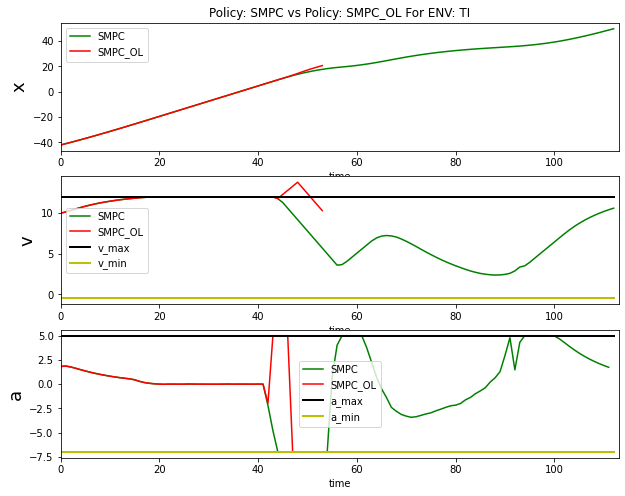

<Figure size 432x288 with 0 Axes>

In [16]:
%matplotlib inline

fig=plt.figure(figsize=(10, 8))
t_f=max(Sim.t,Sim2.t)
a1=plt.subplot(311)
plt.plot(Sim.ev_traj[0,:Sim.t], color='g',linestyle='-', label=Sim.ev_pol)
plt.plot(Sim2.ev_traj[0,:Sim2.t], color='r',linestyle='-', label= Sim2.ev_pol)
plt.xlabel('time')
plt.ylabel('x',fontsize=18)
plt.xlim(0,t_f)
a1.set_title("Policy: "+Sim.ev_pol+" vs Policy: "+Sim2.ev_pol+" For ENV: "+Sim.env)
plt.legend()
a2=plt.subplot(312)
plt.plot(Sim.ev_traj[2,:Sim.t], color='g',linestyle='-', label=Sim.ev_pol)
plt.plot(Sim2.ev_traj[2,:Sim2.t], color='r',linestyle='-', label= Sim2.ev_pol)
plt.plot(smpc2.V_MAX*np.ones(t_f), color='k',linewidth=2.0,linestyle='-', label= 'v_max')
plt.plot(smpc2.V_MIN*np.ones(t_f), color='y',linewidth=2.0,linestyle='-', label= 'v_min')
plt.xlabel('time')
plt.ylabel('v',fontsize=18)
plt.xlim(0,t_f)
plt.legend()
a3=plt.subplot(313)
plt.plot(Sim.ev_u[0,1:Sim.t], color='g',linestyle='-', label=Sim.ev_pol)
plt.plot(Sim2.ev_u[0,1:Sim2.t], color='r',linestyle='-', label= Sim2.ev_pol)
plt.plot(smpc2.A_MAX*np.ones(t_f), color='k',linewidth=2.0,linestyle='-', label= 'a_max')
plt.plot(smpc2.A_MIN*np.ones(t_f), color='y',linewidth=2.0,linestyle='-', label= 'a_min')
plt.xlabel('time')
plt.ylabel('a',fontsize=18)
plt.xlim(0,t_f)
plt.legend()

plt.show()

plt.savefig(Sim.ev_pol+'_vs_'+Sim2.ev_pol+'_'+Sim.env+'.png')


## Animation for Policy 1

In [17]:
%matplotlib notebook

fig= plt.figure()
camera = Camera(fig)

if Env[env_num]=="TI":
    for i in range(Sim.t+1):
        plt.plot([-45, 21], [5, 5], color='k', lw=2)
        plt.plot([-45, 21], [-5, -5], color='k', lw=2)
        plt.plot([41, 50], [5, 5], color='k', lw=2)
        plt.plot([41, 50], [-5, -5], color='k', lw=2)
        plt.plot([21, 21], [5, 30], color='k', lw=2)
        plt.plot([41, 41], [5, 30], color='k', lw=2)
        plt.plot([21, 21], [-5, -30], color='k', lw=2)
        plt.plot([41, 41], [-5, -30], color='k', lw=2)
        plt.plot(Sim.ev_traj[0,:i+1], Sim.ev_traj[1,:i+1], color='green', lw=3)
        if i>0:
            if not feas_list[i-1]:
                plt.text(-20,20, "INFEASIBLE!", fontsize=8, color='r')
            if ca_list[i-1]:
                plt.text(-20,30, "Collision!", fontsize=15, color='r')
        plt.gca().add_patch(Rectangle((Sim.tv_traj[0][0,i]-1.7,Sim.tv_traj[0][1,i]-2.9),3.4,5.8,linewidth=1,edgecolor='r',facecolor='none'))
        plt.gca().add_patch(Rectangle((Sim.tv_traj[1][0,i]-1.7,Sim.tv_traj[1][1,i]-2.9),3.4,5.8,linewidth=1,edgecolor='r',facecolor='none'))
        plt.gca().add_patch(Rectangle((Sim.ev_traj[0,i]-2.9,Sim.ev_traj[1,i]-1.7),5.8,3.4,linewidth=1,edgecolor='g',facecolor='none'))
        plt.axis('equal')
        plt.title("Policy type : "+Sim.ev_pol)
        camera.snap()
else:
    for i in range(Sim.t+1):
        plt.plot([-40, 60], [12, 12], color='k', lw=2)
        plt.plot([-40, 60], [-5, -5], color='k', lw=2)
        plt.plot([-40, 60], [4, 4], color='k', lw=1)
        plt.plot(Sim.ev_traj[0,:i+1], Sim.ev_traj[1,:i+1], color='green', lw=3)
        if i>0:
            if not feas_list[i-1]:
                plt.text(-20,20, "INFEASIBLE!", fontsize=10, color='r')
            if ca_list[i-1]:
                plt.text(-20,30, "Collision!", fontsize=15, color='r')
        plt.gca().add_patch(Rectangle((Sim.tv_traj[0][0,i]-2.9,Sim.tv_traj[0][1,i]-1.7),5.8,3.4,linewidth=1,edgecolor='r',facecolor='none'))
        plt.gca().add_patch(Rectangle((Sim.ev_traj[0,i]-2.9,Sim.ev_traj[1,i]-1.7),5.8,3.4,linewidth=1,edgecolor='g',facecolor='none'))
        plt.axis('equal')
        plt.title("Policy type : "+Sim.ev_pol)
        camera.snap()
    
animation = camera.animate(repeat = True, repeat_delay = 500)
HTML(animation.to_jshtml())
# animation.save('animation_'+Sim.ev_pol+'_'+Sim.env+'.mp4')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


## Animation for Policy 2

In [18]:
%matplotlib notebook

fig= plt.figure()
camera = Camera(fig)

if Env[env_num]=="TI":
    for i in range(Sim2.t+1):
        plt.plot([-45, 21], [5, 5], color='k', lw=2)
        plt.plot([-45, 21], [-5, -5], color='k', lw=2)
        plt.plot([41, 50], [5, 5], color='k', lw=2)
        plt.plot([41, 50], [-5, -5], color='k', lw=2)
        plt.plot([21, 21], [5, 30], color='k', lw=2)
        plt.plot([41, 41], [5, 30], color='k', lw=2)
        plt.plot([21, 21], [-5, -30], color='k', lw=2)
        plt.plot([41, 41], [-5, -30], color='k', lw=2)
        plt.plot(Sim2.ev_traj[0,:i+1], Sim2.ev_traj[1,:i+1], color='green', lw=3)
        if i>0:
            if not feas_list2[i-1]:
                plt.text(-20,20, "INFEASIBLE!", fontsize=10, color='r')
            if ca_list2[i-1]:
                plt.text(-20,30, "Collision!", fontsize=15, color='r')
        plt.gca().add_patch(Rectangle((Sim2.tv_traj[0][0,i]-1.7,Sim2.tv_traj[0][1,i]-2.9),3.4,5.8,linewidth=1,edgecolor='r',facecolor='none'))
        plt.gca().add_patch(Rectangle((Sim2.tv_traj[1][0,i]-1.7,Sim2.tv_traj[1][1,i]-2.9),3.4,5.8,linewidth=1,edgecolor='r',facecolor='none'))
        plt.gca().add_patch(Rectangle((Sim2.ev_traj[0,i]-2.9,Sim2.ev_traj[1,i]-1.7),5.8,3.4,linewidth=1,edgecolor='g',facecolor='none'))
        plt.axis('equal')
        plt.title("Policy type : "+Sim2.ev_pol)
        camera.snap()
else:
    for i in range(Sim2.t):
        plt.plot([-40, 60], [12, 12], color='k', lw=2)
        plt.plot([-40, 60], [-5, -5], color='k', lw=2)
        plt.plot([-40, 60], [4, 4], color='k', lw=1)
        plt.plot(Sim2.ev_traj[0,:i+1], Sim2.ev_traj[1,:i+1], color='green', lw=3)
        if i>0:
            if not feas_list2[i-1]:
                plt.text(-20,20, "INFEASIBLE!", fontsize=10, color='r')
            if ca_list2[i-1]:
                plt.text(-20,30, "Collision!", fontsize=15, color='r')
        plt.gca().add_patch(Rectangle((Sim2.tv_traj[0][0,i]-2.9,Sim2.tv_traj[0][1,i]-1.7),5.8,3.4,linewidth=1,edgecolor='r',facecolor='none'))
        plt.gca().add_patch(Rectangle((Sim2.ev_traj[0,i]-2.9,Sim2.ev_traj[1,i]-1.7),5.8,3.4,linewidth=1,edgecolor='g',facecolor='none'))
        plt.axis('equal')
        plt.title("Policy type : "+Sim2.ev_pol)
        camera.snap()
    
animation = camera.animate(repeat = True, repeat_delay = 500)
HTML(animation.to_jshtml())
# animation.save('animation2_'+Sim2.ev_pol+'_'+Sim2.env+'.mp4')


<IPython.core.display.Javascript object>